In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz
import xarray as xr
import math

from pytensor.tensor.elemwise import scalar_elemwise
from scipy.interpolate import PchipInterpolator

#### Overview
Minecraft returns! However, we are no longer looking at oceans. Instead, we are looking at villages. For context, every biome in Minecraft has a range of possible temperatures (for instance, deserts are hotter than plains are hotter than taigas). The goal of this project is to predict the temperature of a village's biome based on the temperature of the spawn biome. Knowing the nearest village is important for speedrunning, where finding a village is extremely helpful. Temperature is a value visible to players; therefore, this can be a useful statistic in-game. The temperature of the village is the dependent variable, while the temperature of spawn is the independent variable.

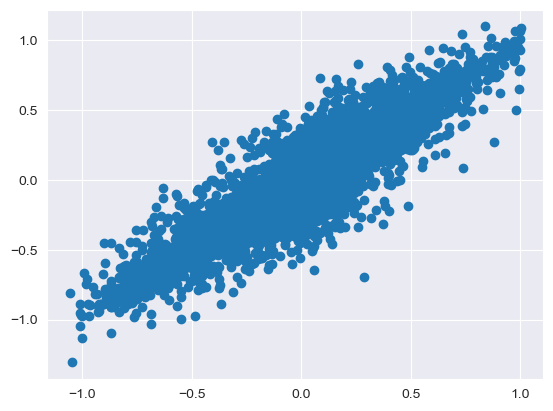

In [3]:
data = pd.read_csv('seedscraper_out.csv')
plt.scatter(data.temperature, data.villageTemperature)

#### Raw Data
Straight off the bat, this sure looks linear. It makes sense that it would be linear because higher spawn temperature means the biomes around it should be hotter, and therefore the village should be hotter. What's interesting to me is that it appears to have a slope of almost exactly 1. This means that in order to find the nearest village, you should seek to maintain the temperature.

Another interesting thing to note is that it appears to deviate from the line more around the middle. This somewhat makes sense, as when the spawn temperature is around 0, the gradient could more easily go either positive or negative.

For our model, that means that the first thing to try is a pure linear model. I'm going to use a normal likelihood since that's a good starting point. The priors are going to be very weak, as I don't really know what to expect here. Since the standard deviation varies too, I'm going to give that its own regression.

In [27]:
with pm.Model() as model_lin:
    α_mu = pm.Normal("α_mu", mu=0, sigma=10) # sort of certain
    β_mu = pm.Normal("β_mu", mu=1, sigma=10) # sort of certain

    μ = pm.Deterministic("μ", α_mu + β_mu * data.temperature)

    α_sigma = pm.Normal("α_sigma", mu=1, sigma=100) # no clue
    β_sigma = pm.Normal("β_sigma", mu=1, sigma=100) # no clue
    σ = pm.Deterministic("σ", α_sigma + β_sigma * data.temperature)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.villageTemperature)

    idata_lin = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_mu, β_mu, α_sigma, β_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### Linear Model
It ran, and it ran fast. That's a good sign. Let's take a look at the posterior predictive.

Sampling: [y_pred]


Text(0, 0.5, 'village temperature')

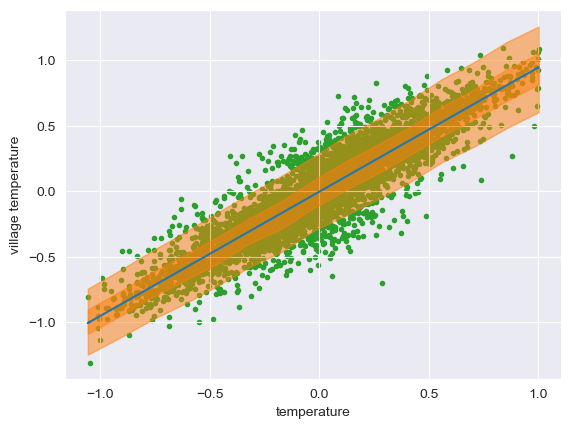

In [29]:
pm.sample_posterior_predictive(idata_lin, model=model_lin,  extend_inferencedata=True)

mean_line = idata_lin.posterior["μ"].mean(("chain", "draw"))

randInp = np.random.normal(data.temperature, 0.01)
idx = np.argsort(randInp)
x = np.linspace(randInp.min(), randInp.max(), 15)

y_pred_q = idata_lin.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(randInp[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(data.temperature, data.villageTemperature, "C2.", zorder=-3)
ax.plot(data.temperature[idx], mean_line[idx], c="C0")


for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("village temperature")

#### Linear Model Predictive
This looks pretty good, though with the pure linear standard deviation, I forgot to account for the fact that it grows bigger then smaller again. It certainly captured the line well, and agrees that it is a slope of ~1 and an intercept of ~0. Before changing anything, let's take a look at the PPC.

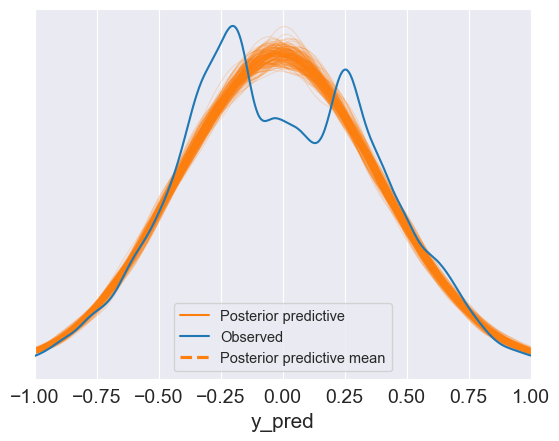

In [50]:
az.plot_ppc(idata_lin, num_pp_samples=200, colors=["C1", "C0", "C1"]).set_xbound(lower=-1, upper=1)

#### Linear Model PPC
Interesting. The data is evidently actually bimodal. I wasn't entirely sure why that was, so I did a little more data scraping -- it actually makes a lot of sense. There are a total of 6 biomes that villages can spawn in: Desert, Savanna, Plains, Meadow, Snowy Plains, and Taiga. Each of those biomes have a range of temperatures they can be:

- Desert:       `0.55` ⸺  `1.00`
- Savanna:      `0.20` ⸺  `0.55`
- Plains:       `-0.45` ⸺ `0.55`
- Meadow:       `-0.45` ⸺ `0.20`
- Taiga:        `-1.00` ⸺ `-0.15`
- Snowy Plains: `-1.00` ⸺ `-0.45`

While I would have expected a lot to have a potential temperature of 0, it's actually only 2/6 (Plains and Meadow). However, 3/6 contain 0.25 (Savanna, Plains, Meadow) and 3/6 contain -0.25 (Taiga, Plains, Meadow). So, while there is a plateau at 0, the actual peaks are at +/- 0.25.

With that in mind, I'm going to change up how we model this. I'm going to split the data into two groups: positive and negative. To confirm that these modes are in fact localized to either side of 0, I'm going to start by putting them through separate models.

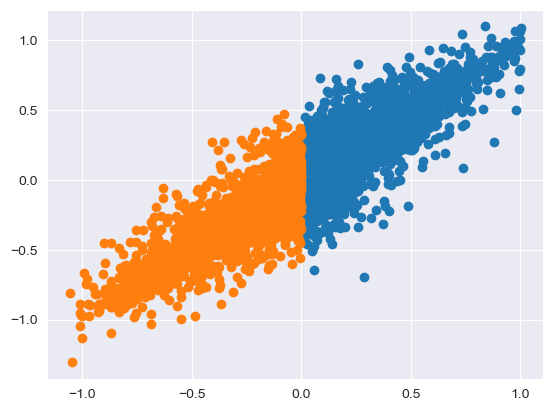

In [59]:
data_split = pd.read_csv('seedscraper_out.csv')
data_split['isPos'] = pd.Series(["pos" if data_split.temperature[i] > 0 else "neg" for i in range(len(data_split))], dtype="category")

isPos_idx = data_split.isPos.cat.codes
isPos_codes = data_split.isPos.cat.categories
isPos_coords = {"isPos": isPos_codes}

plt.scatter(data_split.temperature[data_split.isPos == "pos"], data_split.villageTemperature[data_split.isPos == "pos"])
plt.scatter(data_split.temperature[data_split.isPos == "neg"], data_split.villageTemperature[data_split.isPos == "neg"])

In [51]:
with pm.Model() as model_pos:
    α_mu = pm.Normal("α_mu", mu=0, sigma=10) # sort of certain
    β_mu = pm.Normal("β_mu", mu=1, sigma=10) # sort of certain

    μ = pm.Deterministic("μ", α_mu + β_mu * data_split.temperature[data_split.isPos == "pos"])

    α_sigma = pm.Normal("α_sigma", mu=1, sigma=100) # no clue
    β_sigma = pm.Normal("β_sigma", mu=1, sigma=100) # no clue
    σ = pm.Deterministic("σ", α_sigma + β_sigma * data_split.temperature[data_split.isPos == "pos"])

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data_split.villageTemperature[data_split.isPos == "pos"])

    idata_pos = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_mu, β_mu, α_sigma, β_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [52]:
with pm.Model() as model_neg:
    α_mu = pm.Normal("α_mu", mu=0, sigma=10) # reasonably certain
    β_mu = pm.Normal("β_mu", mu=1, sigma=10) # reasonably certain

    μ = pm.Deterministic("μ", α_mu + β_mu * data_split.temperature[data_split.isPos == "neg"])

    α_sigma = pm.Normal("α_sigma", mu=1, sigma=100) # no clue
    β_sigma = pm.Normal("β_sigma", mu=1, sigma=100) # no clue
    σ = pm.Deterministic("σ", α_sigma + β_sigma * data_split.temperature[data_split.isPos == "neg"])

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data_split.villageTemperature[data_split.isPos == "neg"])

    idata_neg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_mu, β_mu, α_sigma, β_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Sampling: [y_pred]


Sampling: [y_pred]


Text(0, 0.5, 'village temperature')

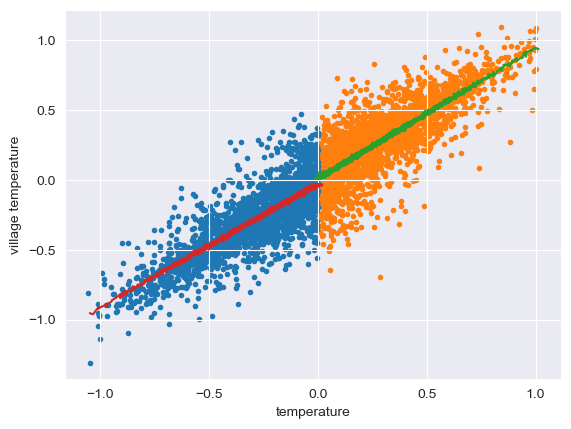

In [53]:
pm.sample_posterior_predictive(idata_pos, model=model_pos,  extend_inferencedata=True)
pm.sample_posterior_predictive(idata_neg, model=model_neg,  extend_inferencedata=True)

mean_line_pos = idata_pos.posterior["μ"].mean(("chain", "draw"))
mean_line_neg = idata_neg.posterior["μ"].mean(("chain", "draw"))

randInp_pos = np.random.normal(data_split.temperature[data_split.isPos == "pos"], 0.01)
idx_pos = np.argsort(randInp_pos)

y_pred_pos = idata_pos.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds_pos = iter(
    [
        PchipInterpolator(randInp_pos[idx_pos], y_pred_pos[i][idx_pos])(x)
        for i in range(4)
    ]
)

randInp_neg = np.random.normal(data_split.temperature[data_split.isPos == "neg"], 0.01)
idx_neg = np.argsort(randInp_neg)

y_pred_neg = idata_neg.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds_neg = iter(
    [
        PchipInterpolator(randInp_neg[idx_neg], y_pred_neg[i][idx_neg])(x)
        for i in range(4)
    ]
)

x = np.linspace(min(randInp_neg.min(), randInp_pos.min()), max(randInp_neg.max(), randInp_pos.max()), 15)

_, ax = plt.subplots()
ax.plot(data_split.temperature[data_split.isPos == "pos"], data_split.villageTemperature[data_split.isPos == "pos"], "C1.", zorder=-3)
ax.plot(randInp_pos[idx_pos], mean_line_pos[idx_pos], c="C2")

ax.plot(data_split.temperature[data_split.isPos == "neg"], data_split.villageTemperature[data_split.isPos == "neg"], "C0.", zorder=-3)
ax.plot(randInp_neg[idx_neg], mean_line_neg[idx_neg], c="C3")

ax.set_xlabel("temperature")
ax.set_ylabel("village temperature")

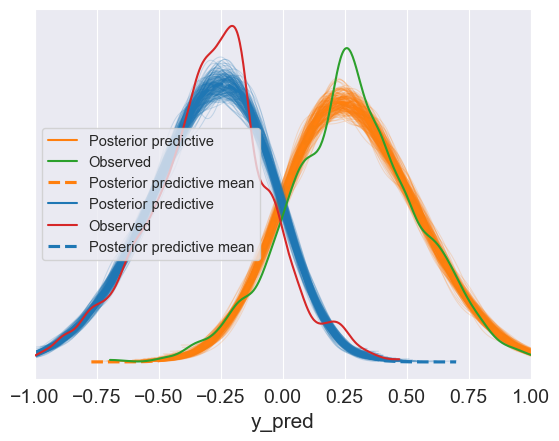

In [54]:
ax = az.plot_ppc(idata_pos, num_pp_samples=200, colors=["C1", "C2", "C1"])
az.plot_ppc(idata_neg, num_pp_samples=200, colors=["C0", "C3", "C0"], ax=ax)
ax.set_xbound(lower=-1, upper=1)

In [61]:
with pm.Model() as model_double_lin:
    α_mu = pm.Normal("α_mu", mu=0, sigma=10) # reasonably certain
    β_mu = pm.Normal("β_mu", mu=1, sigma=10) # reasonably certain
    β2_mu = pm.Normal("β2_mu", mu=1, sigma=10) # reasonably certain

    μ = pm.Deterministic("μ", α_mu + β_mu * data_split.temperature + β2_mu * isPos_idx)

    α_sigma = pm.Normal("α_sigma", mu=1, sigma=100) # no clue
    β_sigma = pm.Normal("β_sigma", mu=1, sigma=100) # no clue
    β2_sigma = pm.Normal("β2_sigma", mu=1, sigma=100) # no clue
    σ = pm.Deterministic("σ", α_sigma + β_sigma * data_split.temperature + β2_sigma * isPos_idx)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data_split.villageTemperature)

    idata_double_lin = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_mu, β_mu, β2_mu, α_sigma, β_sigma, β2_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Sampling: [y_pred]


Text(0, 0.5, 'village temperature')

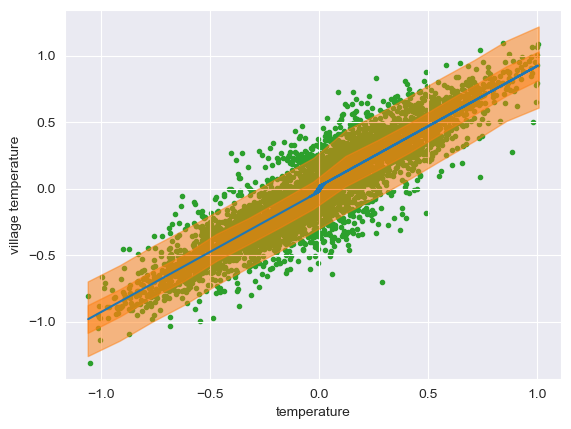

In [62]:
pm.sample_posterior_predictive(idata_double_lin, model=model_double_lin,  extend_inferencedata=True)

mean_line = idata_double_lin.posterior["μ"].mean(("chain", "draw"))

randInp = np.random.normal(data.temperature, 0.01)
idx = np.argsort(randInp)
x = np.linspace(randInp.min(), randInp.max(), 15)

y_pred_q = idata_double_lin.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(randInp[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(data.temperature, data.villageTemperature, "C2.", zorder=-3)
ax.plot(data.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("village temperature")

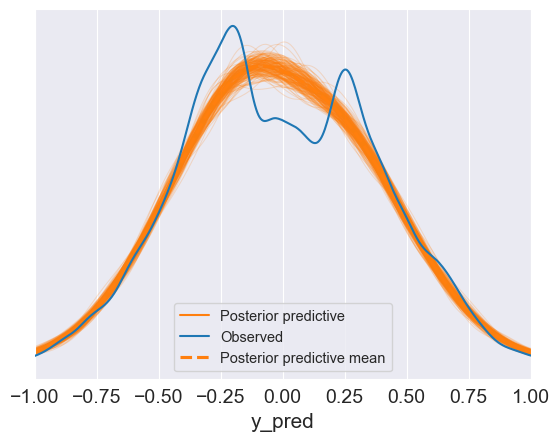

In [63]:
az.plot_ppc(idata_double_lin, num_pp_samples=200, colors=["C1", "C0", "C1"]).set_xbound(lower=-1, upper=1)